In [1]:
import os
import sys
import math
import random

from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append("../../")

from helpers.assess import resolve_sample_weight, make_classification_report, make_confusion_matrix
from helpers.split import make_train_test_split, tag_label_feature_split


from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)

In [2]:
file = os.path.join(Path().absolute().parents[1], 'datasets', 'dataset_10_melspecs_no_pop.pickle')
df = pd.read_pickle(file)

In [3]:
def split10(array):
    return np.array_split(array[:, 0:680], 10, axis=1)

In [4]:
df['melspec'] = df['melspec'].apply(split10)
df = df.explode(['melspec']).reset_index(drop=True)
df1 = df.sample(frac=1) #shuffle

In [5]:
_, (y, le), X = tag_label_feature_split(
    df1, label_format="encoded"
)

In [6]:
def crop_center(X,cropx,cropy):
    _, y,x = X.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return X[:, starty:starty+cropy,startx:startx+cropx]

In [7]:
# extract 2D numpy array from pandas dataframe
X = np.array(list(X.to_numpy()[:,0]))
print(X.shape)
# choosing ~5s clip to make square 96x96 spectrogram frame
# X = crop_center(X, 341, 96) # 683 is around 30s

print(X.shape)

scaler = StandardScaler()
# flatten 2D array to fit to "overall" mean / variance
scaler.fit(X.reshape(-1,1))
# must be reshaped for transformation then restored to original shape
X = scaler.transform(X.reshape(-1, 1)).reshape(X.shape)

# add a dimension from (n, 96, 96) to (n, 96, 96, 1)
X = np.expand_dims(X, axis=-1)

(160080, 96, 68)
(160080, 96, 68)


In [8]:
print(X.shape)

(160080, 96, 68, 1)


In [9]:
X_train, X_test, y_train, y_test = make_train_test_split(
        X, y, test_size=0.1, random_state=9, stratify=y
    )

X_train, X_validation, y_train, y_validation = make_train_test_split(
        X_train, y_train, test_size=0.3, random_state=9, stratify=y_train
    )

class_weight={i:c  for i,c in enumerate(compute_class_weight(class_weight='balanced',classes=le.transform(le.classes_),y=y_train))}

In [10]:
print(np.squeeze(X_train, axis = -1).shape)

(100850, 96, 68)


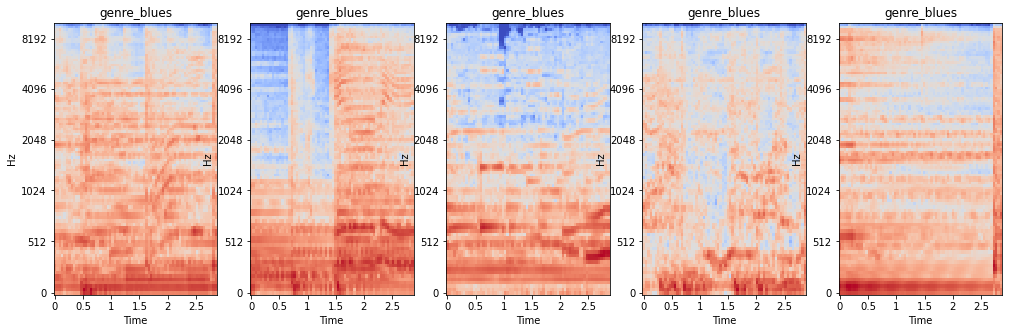

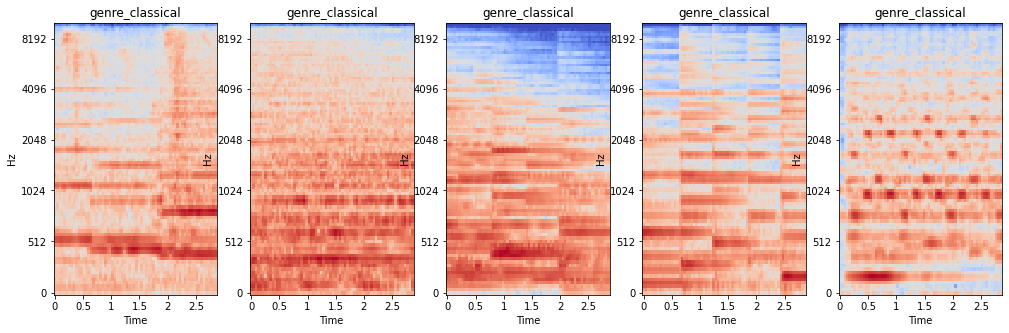

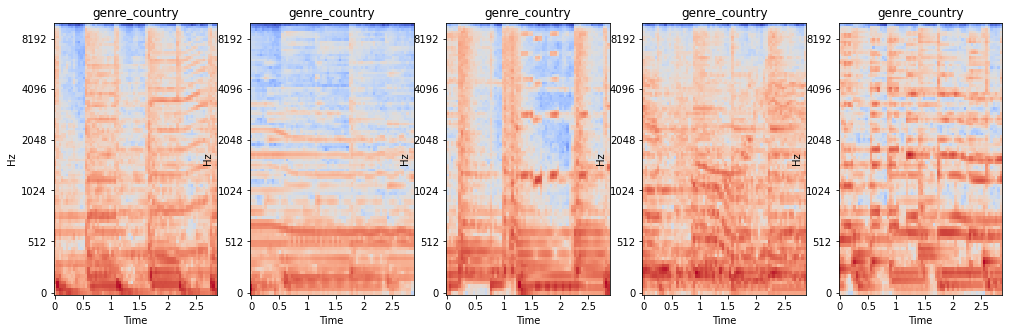

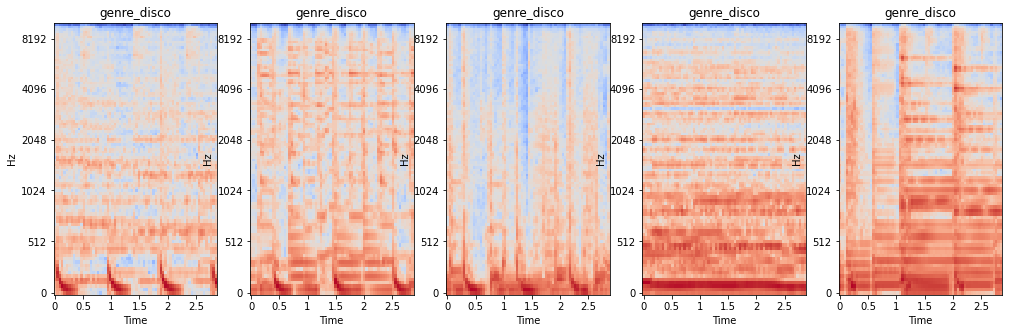

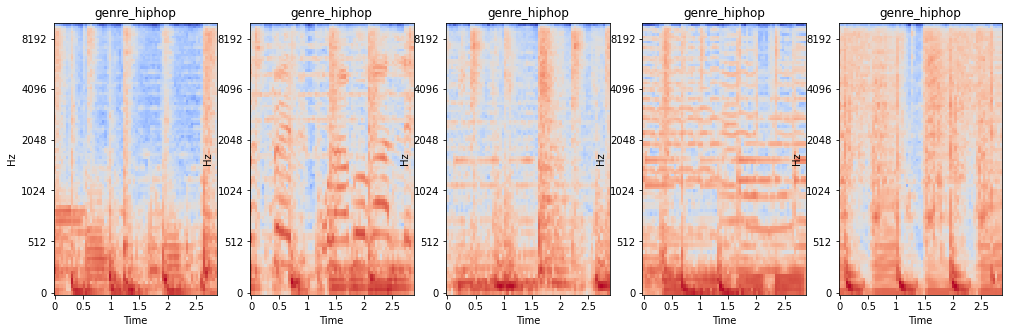

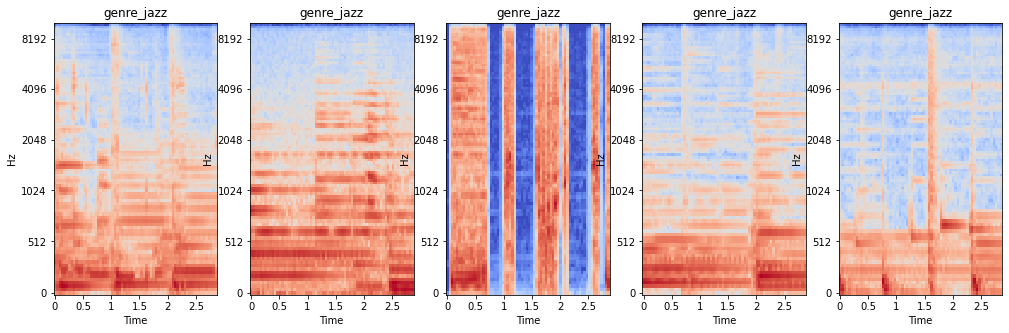

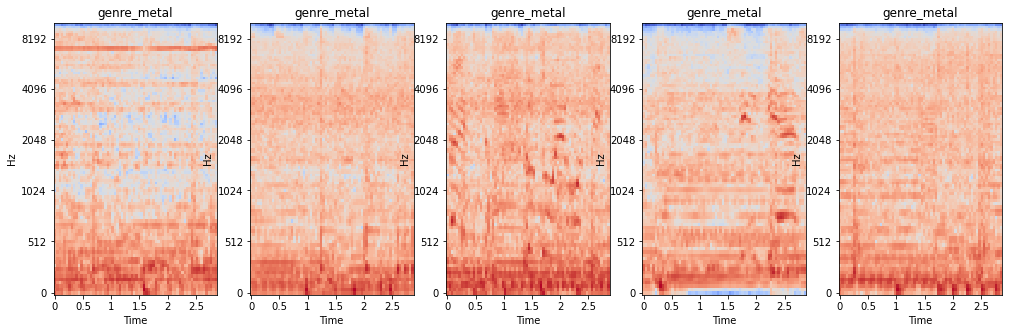

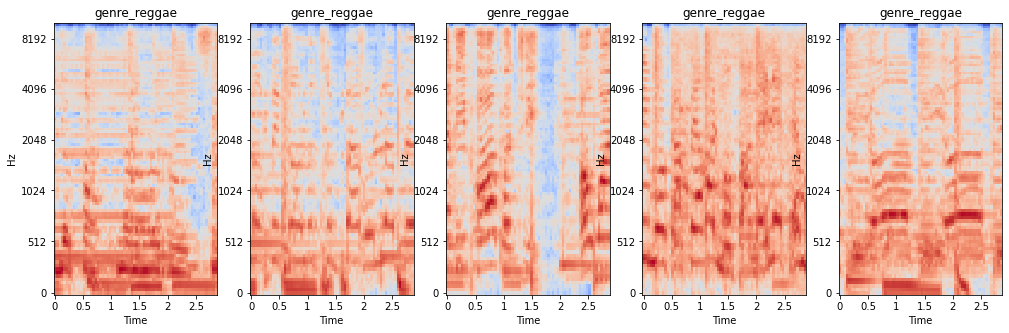

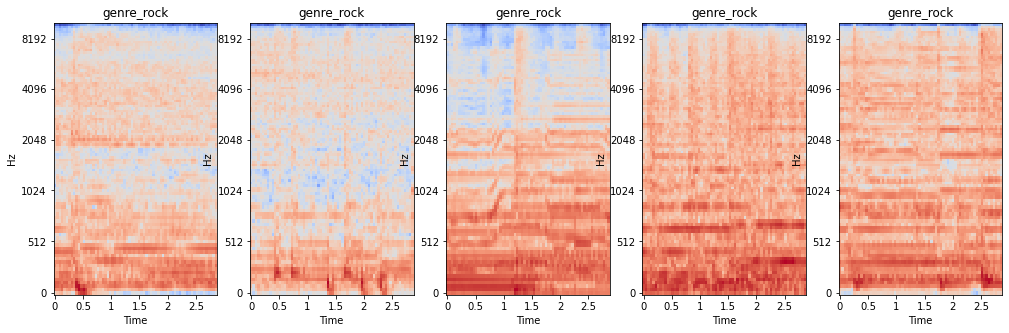

In [11]:
import librosa
import librosa.display

for l in range(9):
    nrows, ncols = 1,5 #print first 4 images
    f, axs = plt.subplots(nrows, ncols, figsize=(17,5))
    tempArr = X_train[y_train == l, :]
    label = le.inverse_transform([l])[0]
    num = 0
    for i in range(ncols):
        img = librosa.display.specshow(np.squeeze(tempArr[num], axis = -1), x_axis='time',
                            y_axis='mel', sr=12000,
                            fmax=10000, ax=axs[i])
        axs[i].set(title=label)
        num += 1
    plt.show()

In [12]:
print(X_train.shape)

(100850, 96, 68, 1)


In [13]:
def build_model(
    filters=[64],
    kernal_size=[16],
    strides=(1, 1),
    padding='same',
    activation='relu',
    pool_size=(2,2),
    batch_normalization=False,
    batch_axis=None,
    dense_units=[1024],
    dropout_rate=0.5,
    input_shape=(None, 96, 96, 1),
    last_activation=None
):
    param = {
        'filters': filters,
        'kernal_size': kernal_size,
        'strides': strides,
        'padding': padding,
        'activation': activation,
        'pool_size': pool_size,
        'dense_units': dense_units,
        'dropout_rate': dropout_rate,
        'input_shape': input_shape,
        'batch_normalization': batch_normalization,
        'batch_axis': batch_axis,
        'last_activation': last_activation
    }
    model = tf.keras.Sequential()

    for i in range(len(filters)):
        model.add(
            tf.keras.layers.Conv2D(
                filters=filters[i],
                kernel_size=kernal_size[i],
                strides=strides,
                padding=padding,
                name=f'conv_{i}',
                activation=activation
            )
        )
        
        if batch_normalization:
            tf.keras.layers.BatchNormalization(batch_axis[i])

        model.add(
            tf.keras.layers.MaxPool2D(
                pool_size=pool_size,
                name=f'pool_{i}'
            )
        )

        if type(dropout_rate) == list:
            model.add(
                tf.keras.layers.Dropout(
                    rate=dropout_rate[i],
                    name=f'dropout_{i}'
                )
            )

    model.add(tf.keras.layers.Flatten()) 

    for l in range(len(dense_units)):
        model.add( 
            tf.keras.layers.Dense(
                units=dense_units[l],
                name=f'fc_{l}', 
                activation=activation
            )
        )

    if type(dropout_rate) == float:
        model.add(
            tf.keras.layers.Dropout(
                rate=dropout_rate
            )
        )

    model.add(
        tf.keras.layers.Dense(
            units=9,
            name='fc_last',
            activation=last_activation
        )
    )

    tf.random.set_seed(1)
    model.build(input_shape=input_shape)
    print(model.summary())

    return model, param



using model from https://towardsdatascience.com/music-genre-recognition-using-convolutional-neural-networks-cnn-part-1-212c6b93da76

In [14]:
from tensorflow.keras import backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked

class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    """Computes the Matthews Correlation Coefficient.
    The statistic is also known as the phi coefficient.
    The Matthews correlation coefficient (MCC) is used in
    machine learning as a measure of the quality of binary
    and multiclass classifications. It takes into account
    true and false positives and negatives and is generally
    regarded as a balanced measure which can be used even
    if the classes are of very different sizes. The correlation
    coefficient value of MCC is between -1 and +1. A
    coefficient of +1 represents a perfect prediction,
    0 an average random prediction and -1 an inverse
    prediction. The statistic is also known as
    the phi coefficient.
    MCC = (TP * TN) - (FP * FN) /
          ((TP + FP) * (TP + FN) * (TN + FP ) * (TN + FN))^(1/2)
    Args:
        num_classes : Number of unique classes in the dataset.
        name: (Optional) String name of the metric instance.
        dtype: (Optional) Data type of the metric result.
    Usage:
    >>> y_true = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0]], dtype=np.float32)
    >>> y_pred = np.array([[0.0, 1.0], [1.0, 0.0], [0.0, 1.0], [0.0, 1.0]], dtype=np.float32)
    >>> metric = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
    >>> metric.update_state(y_true, y_pred)
    >>> result = metric.result()
    >>> result.numpy()
    -0.33333334
    """

    @typechecked
    def __init__(
        self,
        num_classes: FloatTensorLike,
        name: str = "MatthewsCorrelationCoefficient",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        """Creates a Matthews Correlation Coefficient instance."""
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.conf_mtx = self.add_weight(
            "conf_mtx",
            shape=(self.num_classes, self.num_classes),
            initializer=tf.keras.initializers.zeros,
            dtype=self.dtype,
        )

    # TODO: sample_weights
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=self.dtype)
        y_pred = tf.cast(y_pred, dtype=self.dtype)
        
        y_pred = tf.math.argmax(y_pred, axis=1)
        y_pred = tf.squeeze(y_pred)
        y_pred = tf.cast(y_pred, tf.int32)
        y_pred = tf.one_hot(y_pred, self.num_classes)
        
        y_true = tf.squeeze(y_true)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, self.num_classes)
        
        new_conf_mtx = tf.math.confusion_matrix(
            labels=tf.argmax(y_true, 1),
            predictions=tf.argmax(y_pred, 1),
            num_classes=self.num_classes,
            weights=sample_weight,
            dtype=self.dtype,
        )

        self.conf_mtx.assign_add(new_conf_mtx)

    def result(self):
        
        true_sum = tf.reduce_sum(self.conf_mtx, axis=1)
        pred_sum = tf.reduce_sum(self.conf_mtx, axis=0)
        num_correct = tf.linalg.trace(self.conf_mtx)
        num_samples = tf.reduce_sum(pred_sum)
        
        # covariance true-pred
        cov_ytyp = num_correct * num_samples - tf.tensordot(true_sum, pred_sum, axes=1)
                
        # covariance pred-pred
        cov_ypyp = num_samples**2 - tf.tensordot(pred_sum, pred_sum, axes=1)
        
        # covariance true-true
        cov_ytyt = num_samples**2 - tf.tensordot(true_sum, true_sum, axes=1)
        
        mcc = cov_ytyp / tf.math.sqrt(cov_ytyt * cov_ypyp)

        if tf.math.is_nan(mcc):
            mcc = tf.constant(0, dtype=self.dtype)

        return mcc

    def get_config(self):
        """Returns the serializable config of the metric."""
        config = {
            "num_classes": self.num_classes,
        }
        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        """Resets all of the metric state variables."""
        for v in self.variables:
            K.set_value(
                v,
                np.zeros((self.num_classes, self.num_classes), v.dtype.as_numpy_dtype),
            )
#         self.conf_mtx.assign(0)

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()

c:\Users\alvin\anaconda3\envs\W207_project\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [16]:
model3, param3 = build_model(
    filters=[16, 32, 64, 128],
    kernal_size=[(3,3), (3,3), (3,3), (3,3)],
    strides=(1, 1),
    padding='same',
    activation='relu',
    batch_normalization=True,
    batch_axis=[3, 3, -1, -1],
    pool_size=(2,2),
    dense_units=[],
    dropout_rate=[0.3, 0.3, 0.3, 0.3],
    input_shape=(None, 96, 68, 1),
    last_activation='softmax'
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_0 (Conv2D)              (None, 96, 68, 16)        160       
_________________________________________________________________
pool_0 (MaxPooling2D)        (None, 48, 34, 16)        0         
_________________________________________________________________
dropout_0 (Dropout)          (None, 48, 34, 16)        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 48, 34, 32)        4640      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 24, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 17, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 24, 17, 64)        1

In [17]:
learning_rate = 0.00055
epoch = 100

param3['learning_rate'] = learning_rate
param3['epoch'] = epoch

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50000,
    decay_rate=0.96,
)

param3['decay'] = True
param3['decay_steps'] = 50000
param3['decay_rate'] = 0.96

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', get_f1]
    # metrics=[MatthewsCorrelationCoefficient(num_classes=10)]
)

In [18]:
tf.random.set_seed(1234)
np.random.seed(1234)
hist3 = model3.fit(
    X_train,
    y_train,
    epochs=epoch, 
    validation_data=(X_validation,y_validation),
    class_weight=class_weight,
    # verbose=0
)



Epoch 1/100
3152/3152 [==============================] - 24s 7ms/step - loss: 1.6352 - accuracy: 0.4722 - get_f1: 4.1995 - val_loss: 1.3940 - val_accuracy: 0.5477 - val_get_f1: 4.1057
Epoch 2/100
3152/3152 [==============================] - 20s 6ms/step - loss: 1.4197 - accuracy: 0.5518 - get_f1: 3.2217 - val_loss: 1.3451 - val_accuracy: 0.5509 - val_get_f1: 3.5088
Epoch 3/100
3152/3152 [==============================] - 21s 7ms/step - loss: 1.3294 - accuracy: 0.5744 - get_f1: 2.9362 - val_loss: 1.1573 - val_accuracy: 0.5975 - val_get_f1: 2.9901
Epoch 4/100
3152/3152 [==============================] - 21s 7ms/step - loss: 1.2709 - accuracy: 0.5882 - get_f1: 2.7836 - val_loss: 1.1222 - val_accuracy: 0.6013 - val_get_f1: 2.9578
Epoch 5/100
3152/3152 [==============================] - 20s 6ms/step - loss: 1.2295 - accuracy: 0.5997 - get_f1: 2.6866 - val_loss: 1.2151 - val_accuracy: 0.5641 - val_get_f1: 2.9777
Epoch 6/100
3152/3152 [==============================] - 20s 6ms/step - loss: 1.

After fine-tuning this model, evaluation on the validation data shows an accuracy of: 66.38 %


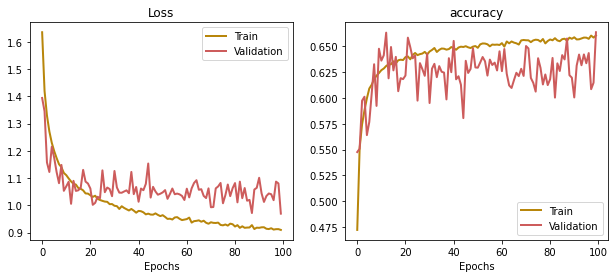

In [19]:
# grab history
history3 = hist3.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history3['loss'], lw=2, color='darkgoldenrod')
plt.plot(history3['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')

# plot accuracy for train and validation
# ax = fig.add_subplot(1, 3, 2)
# plt.plot(history3['MatthewsCorrelationCoefficient'], lw=2, color='darkgoldenrod')
# plt.plot(history3['val_MatthewsCorrelationCoefficient'], lw=2, color='indianred')
# plt.legend(['Train', 'Validation'], fontsize=10)
# #plt.ylim(0.7,0.8)
# ax.set_xlabel('Epochs', size=10)
# ax.set_title('MatthewsCorrelationCoefficient')

# print('After fine-tuning this model, evaluation on the validation data shows MatthewsCorrelationCoefficient of:',
#       np.round(history3['val_MatthewsCorrelationCoefficient'][-1]*100,2), '%'
# )

ax = fig.add_subplot(1, 3, 2)
plt.plot(history3['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history3['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('accuracy')

print('After fine-tuning this model, evaluation on the validation data shows an accuracy of:',
      np.round(history3['val_accuracy'][-1]*100,2), '%'
)

In [20]:
y_pred = model3.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [25]:
make_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    model=model3,
    x = X_test,
    save_result=True,
    label_encoder=le,
    model_name='CNN_melspec_partitioned_no_pop_3s_2',
    dataset_name='dataset_10_melspecs_partitioned',
    phase='train',
    additional_result_param=param3,
    repeat=False,
    result_filename='alvin_melspec_CNN.json',
    print_report=True
)


c:\Users\alvin\OneDrive - UCLA IT Services\Berkeley MIDS\W207\final_project\member_workspaces\alvin\..\..\results\alvin_melspec_CNN.json
file exist, reading json
record saved
                   precision  recall  f1-score  support   mcc
                                                             
      genre_blues       0.21    0.39      0.27      468  0.25
  genre_classical       0.85    0.89      0.87     5276  0.81
    genre_country       0.27    0.72      0.39      409  0.41
      genre_disco       0.26    0.83      0.39      361  0.44
     genre_hiphop       0.79    0.62      0.70     2126  0.66
       genre_jazz       0.60    0.50      0.54     1552  0.50
      genre_metal       0.46    0.69      0.55      831  0.53
     genre_reggae       0.66    0.61      0.63      985  0.61
       genre_rock       0.81    0.44      0.57     4000  0.52
                                                             
         accuracy                         0.66    16008  0.59
        macro avg  

'                   precision  recall  f1-score  support   mcc\n                                                             \n      genre_blues       0.21    0.39      0.27      468  0.25\n  genre_classical       0.85    0.89      0.87     5276  0.81\n    genre_country       0.27    0.72      0.39      409  0.41\n      genre_disco       0.26    0.83      0.39      361  0.44\n     genre_hiphop       0.79    0.62      0.70     2126  0.66\n       genre_jazz       0.60    0.50      0.54     1552  0.50\n      genre_metal       0.46    0.69      0.55      831  0.53\n     genre_reggae       0.66    0.61      0.63      985  0.61\n       genre_rock       0.81    0.44      0.57     4000  0.52\n                                                             \n         accuracy                         0.66    16008  0.59\n        macro avg       0.54    0.63      0.55    16008      \n     weighted avg       0.73    0.66      0.67    16008      \n              min       0.21    0.39      0.27      36

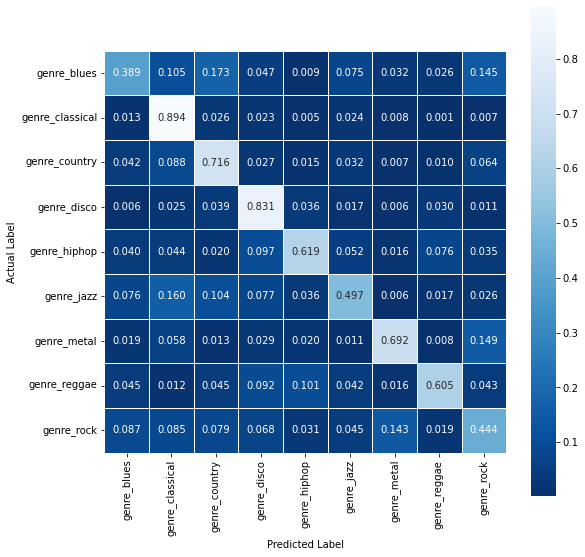

array([[0.38888889, 0.10470085, 0.17307692, 0.04700855, 0.00854701,
        0.07478632, 0.03205128, 0.02564103, 0.14529915],
       [0.01250948, 0.8944276 , 0.0257771 , 0.02331312, 0.00473844,
        0.02369219, 0.0075815 , 0.00113723, 0.00682335],
       [0.04156479, 0.08801956, 0.71638142, 0.02689487, 0.01466993,
        0.03178484, 0.00733496, 0.00977995, 0.06356968],
       [0.00554017, 0.02493075, 0.03878116, 0.83102493, 0.03601108,
        0.0166205 , 0.00554017, 0.03047091, 0.01108033],
       [0.03998119, 0.04421449, 0.02022578, 0.09736595, 0.61947319,
        0.05221072, 0.01552211, 0.07619944, 0.03480715],
       [0.07603093, 0.16043814, 0.10438144, 0.07667526, 0.03608247,
        0.49677835, 0.00579897, 0.01739691, 0.02641753],
       [0.01925391, 0.05776173, 0.01323706, 0.02888087, 0.02045728,
        0.01083032, 0.69193742, 0.00842359, 0.14921781],
       [0.04467005, 0.01218274, 0.04467005, 0.09238579, 0.10050761,
        0.04162437, 0.01624365, 0.60507614, 0.04263959],


In [24]:
make_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    model=model3,
    x = X_test,
    normalize="true",  
    # sample_weight=list(class_weight.values()), 
    autoweight_sample=True,  
    print_heatmap=True, 
    label_encoder=le,  
    figsize=(9, 9),  
)